In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import sklearn
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.manifold import Isomap
import seaborn as sn

In [14]:
sr = pd.read_csv("data/speech_reading.csv")
sm = pd.read_csv("data/speech_monologue.csv")
sr = sr.add_suffix("_reading")
sm = sm.add_suffix("_monologue")

# NOTES:
- Jeste by mozna stalo za hrich zkusit clustrovani i podle pohlavi treba?
- Treba by to mohlo vysvetlit ty mensi clustriky co jsou u UMAPU
- krizek -> chlap, kolecko -> zenska, treba

# Clustering with LDA
- Remember that LDA makes assumptions about normally distributed classes and equal class covariances.

In [15]:
# plot helpers
lw = 2
colors = ["navy", "turquoise", "darkorange"]
target_names = ["PD", "RD", "HC"]
labels = [1, 2, 3]

lda = LinearDiscriminantAnalysis(n_components=2)

### Clustering for reading only

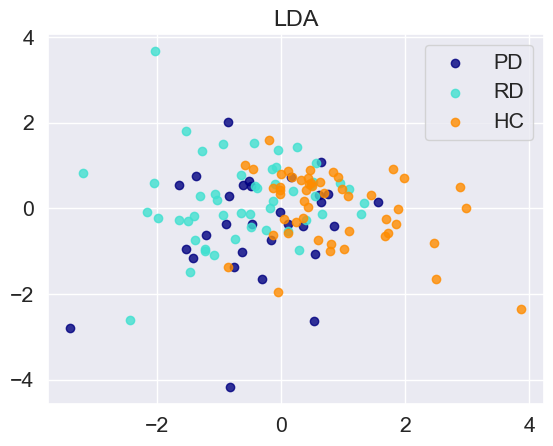

In [16]:
X = sr.drop('group_reading', axis=1)
y = sr['group_reading']

X_2comp = lda.fit(X, y).transform(X)

plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_2comp[y == i, 0], X_2comp[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA")
plt.show()

### Clustering for monologue only

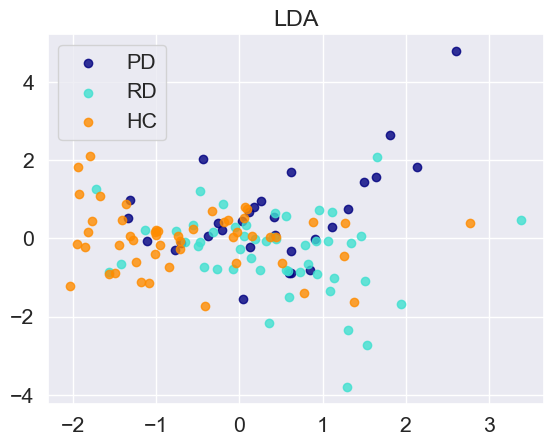

In [17]:
X = sm.drop('group_monologue', axis=1)
y = sm['group_monologue']

X_2comp = lda.fit(X, y).transform(X)

plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_2comp[y == i, 0], X_2comp[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA")

plt.show()

### Clustering with LDA using monologue + reading
- we can see 3, albeit overlapping clusters, meaning that the groups can be separated by these variables but not super well

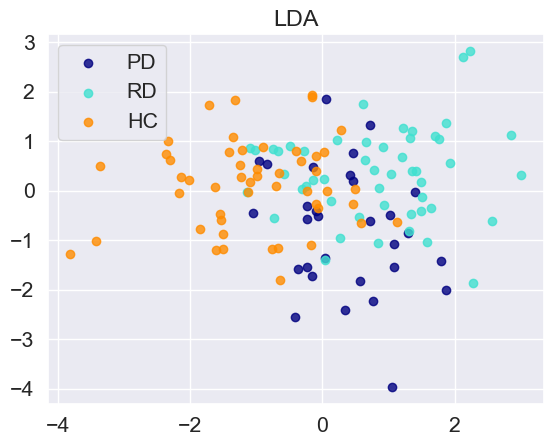

In [18]:
# Join data horizontaly
sr = sr.drop("group_reading", axis=1)
data = pd.concat([sr, sm], axis=1)
data.rename(columns = {'group_monologue':'group'}, inplace=True)

X = data.drop('group', axis = 1)
y = data['group']

X_2comp = lda.fit(X, y).transform(X)

plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_2comp[y == i, 0], X_2comp[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA")

plt.show()

# PCA

explained variance [0.44918608 0.26816147]


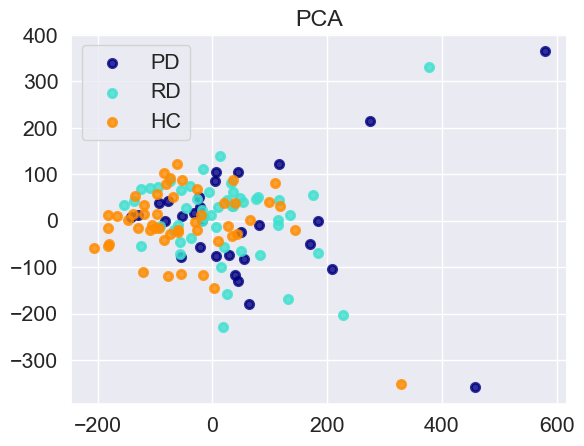

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)
print(f"explained variance {pca.explained_variance_ratio_}")

plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

plt.show()

explained variance [0.44918608 0.26816147 0.11968616]


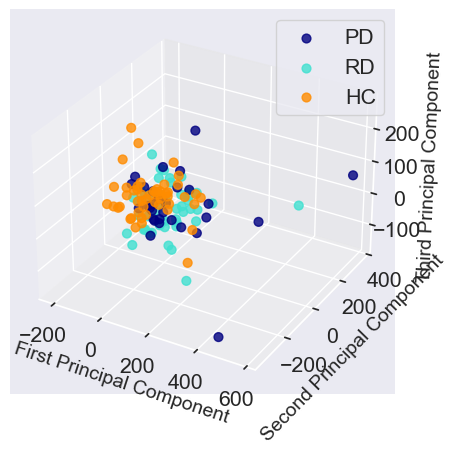

In [20]:
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
print(f"explained variance {pca.explained_variance_ratio_}")

cdict = {1:'navy',2:'turquoise', 3:'darkorange'}
labl = {1:'PD',2:'RD', 3:'HC'}

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], alpha=0.8)

# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()

## Nelinearni clustering

- To se dela na zaklade toho ktere body jsou u sebe blizko, (blizko ve vysoke dim. == blizko v nizke dim.)
- UMAP vychazi asi docela pekne? Jsou tam takove mensi clustriky rozdelene
    - HC jsou v takovem bananu
    - vpravo je hodne HC a par RD, a skoro zadny PD
    - vlevo nahore je vetsi cluster modrych spolu a vlevo dole je mensi cluster modrych spolu

### UMAP

Text(0.5, 1.0, 'UMAP')

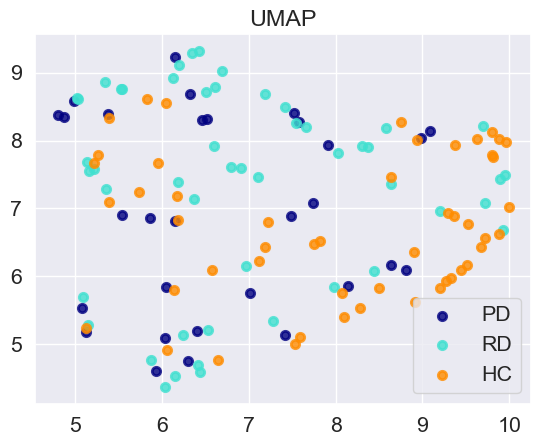

In [56]:
X_umap = umap.UMAP(n_neighbors = 10, min_dist=0.01).fit_transform(X)

# Setting the background color of the plot
plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_umap[y == i, 0], X_umap[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP")

### Isomap

Text(0.5, 1.0, 'Isomap')

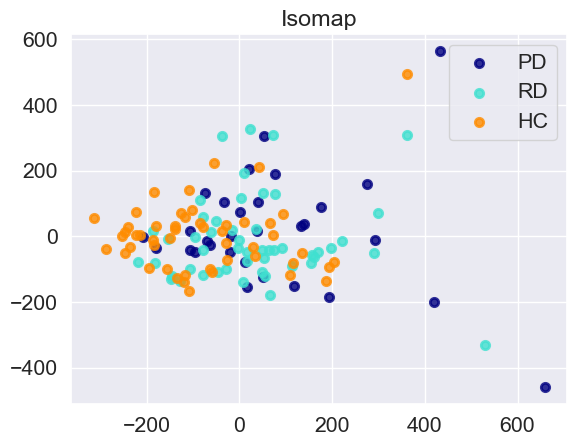

In [37]:
embedding = Isomap(n_neighbors=6)

X_imap = embedding.fit_transform(X)

plt.figure()
for color, i, target_name in zip(colors, labels, target_names):
    plt.scatter(
        X_imap[y == i, 0], X_imap[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Isomap")

# Feature selection
- logistic regression with L1 regularization can remove variables with low predictive power from the dataset

## Variables sorted by their predictive power, displaying first 8
- using l1 regularization
- both give very similar results
- out of the first 8 most significant 
    - 6 - monologue
    - 2 - reading
    - monologue seems to be a better predictor than reading => mozna je monolog vice ovlivneny nemoci nez reading?

In [23]:
num_of_variables_displayed = 8

[['PauseInt_monologue' 1.4035611541796043]
 ['SpeechRate_reading' 0.5551389697107713]
 ['GapingInt_monologue' 0.4996709751762333]
 ['SpeechAcceleration_monologue' 0.4067598820915187]
 ['SpeechRate_monologue' 0.37022825635278]
 ['UnvoicedStops_monologue' 0.34192761577477665]
 ['RespirationPauseInt_monologue' 0.3395011738259026]
 ['RespirationSpeechRate_reading' 0.3068070641257483]]


<AxesSubplot:>

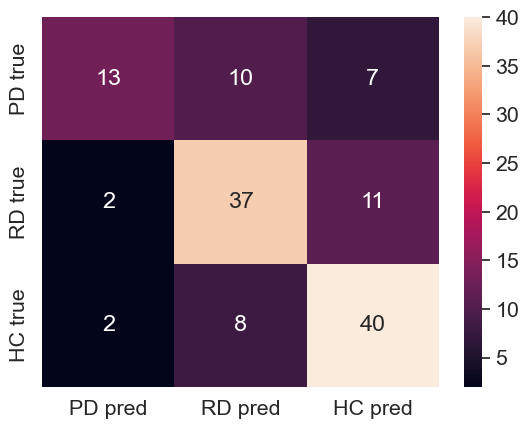

In [24]:
# Standardize the train and test sample
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform GridSearchCV to tune best-fit LR model
param = {'C': np.linspace(10**-2, 10**2, 15)}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_std, y)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_std, y)

d = np.column_stack((np.array(X.columns),abs(model.coef_[0])))
significant_varsl1 = d[d[:, 1].argsort()][::-1]
print(significant_varsl1[:num_of_variables_displayed])

y_pred = model.predict(X_std)

cmtx = confusion_matrix(y, y_pred, labels=[1, 2, 3])

df_cm = pd.DataFrame(cmtx, columns=["PD pred","RD pred","HC pred"])
df_cm.index = ["PD true","RD true","HC true"]
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size

- with l2 regularization

[['PauseInt_monologue' 1.4190912227052896]
 ['SpeechRate_reading' 0.5987675421317262]
 ['GapingInt_monologue' 0.5074981531893318]
 ['SpeechRate_monologue' 0.4123060306877723]
 ['SpeechAcceleration_monologue' 0.4056549096372795]
 ['UnvoicedStops_monologue' 0.3452049423926045]
 ['RespirationPauseInt_monologue' 0.341611306572605]
 ['RespirationSpeechRate_reading' 0.32932984223260126]]


<AxesSubplot:>

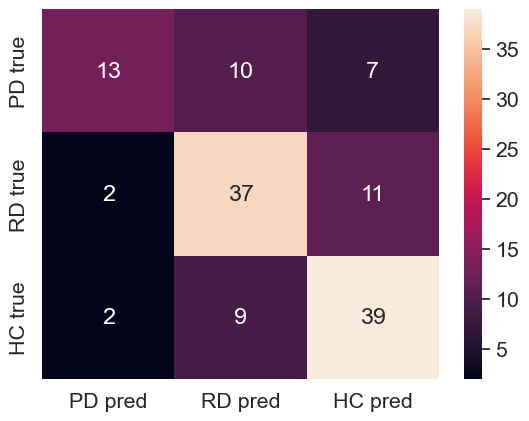

In [25]:
# Standardize the train and test sample
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform GridSearchCV to tune best-fit LR model
param = {'C': np.linspace(10**-2, 10**2, 15)}

lr_model = LogisticRegression(penalty='l2', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_std, y)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, solver='liblinear')

model.fit(X_std, y)

d = np.column_stack((np.array(X.columns),abs(model.coef_[0])))
print(d[d[:, 1].argsort()][::-1][:num_of_variables_displayed])

y_pred = model.predict(X_std)

cmtx = confusion_matrix(y, y_pred, labels=[1, 2, 3])

df_cm = pd.DataFrame(cmtx, columns=["PD pred","RD pred","HC pred"])
df_cm.index = ["PD true","RD true","HC true"]
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size